In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [4]:
epoch_n_91t, wavelength_nugent_91t, flux_nugent_91t = np.loadtxt('../data/info_files/nugent_91t_templates.dat', unpack = True)
epoch_n_91bg, wavelength_nugent_91bg, flux_nugent_91bg = np.loadtxt('../data/info_files/nugent_91bg_templates.dat', unpack = True)

In [5]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_m2 = flux_salt - 3.06*salt_corr #dm15=1.61
flux_salt_p1 = flux_salt + 1.85*salt_corr #dm15=.84
# flux_salt_m2 = flux_salt - 2.68*salt_corr #using fit from guy07
# flux_salt_p1 = flux_salt + 1.76*salt_corr #using fit from guy07

In [6]:
salt_temps_m2 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_m2[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_m2[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_m2[i])
    first = False
    
salt_temps_p1 = {}
phase_list = []
first = True
for i, phase in enumerate(phase_s):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            salt_temps_p1[float(phase_s[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_salt[i]]
        temp_flux = [flux_salt_p1[i]]
    else:
        temp_wave.append(wavelength_salt[i])
        temp_flux.append(flux_salt_p1[i])
    first = False

In [7]:
nug_temps_91t = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91t):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91t[float(epoch_n_91t[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91t[i]]
        temp_flux = [flux_nugent_91t[i]]
    else:
        temp_wave.append(wavelength_nugent_91t[i])
        temp_flux.append(flux_nugent_91t[i])
    first = False
    
nug_temps_91bg = {}
phase_list = []
first = True
for i, phase in enumerate(epoch_n_91bg):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            nug_temps_91bg[float(epoch_n_91bg[i-1]) - 20.] = [temp_wave, temp_flux]
        temp_wave = [wavelength_nugent_91bg[i]]
        temp_flux = [flux_nugent_91bg[i]]
    else:
        temp_wave.append(wavelength_nugent_91bg[i])
        temp_flux.append(flux_nugent_91bg[i])
    first = False

In [8]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    return s_template

In [9]:
m2_salt_template = make_obj_from_template(salt_temps_m2[0.][0], salt_temps_m2[0.][1])
p1_salt_template = make_obj_from_template(salt_temps_p1[0.][0], salt_temps_p1[0.][1])
nug91t_template = make_obj_from_template(nug_temps_91t[0.][0], nug_temps_91t[0.][1])
nug91bg_template = make_obj_from_template(nug_temps_91bg[0.][0], nug_temps_91bg[0.][1])

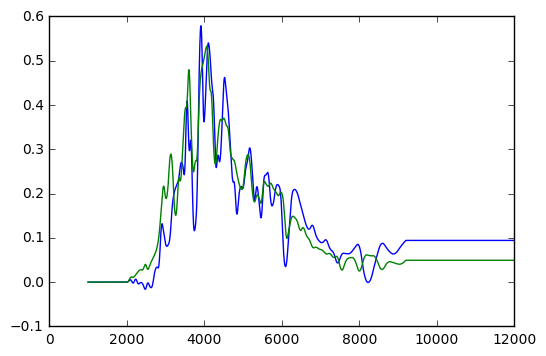

In [10]:
plt.plot(m2_salt_template.wavelength, m2_salt_template.flux)
plt.plot(p1_salt_template.wavelength, p1_salt_template.flux)
plt.show()

In [11]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'"]

In [12]:
composites_p1, sn_arrays_p1, boot_sn_arrays_p1 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -1 and phase <= 1 and ((dm15_source <= .9) or (dm15_from_fits <= .9)) and Supernovae.SN !='2002bf'
173 questionable files currently ignored
(0, 'questionable spectra removed', 23, 'spectra left')
(0, 'Peculiar Ias removed', 23, 'spectra left')
23 spectra with host corrections
173 questionable files currently ignored
15 valid SNe found
Arrays cleaned
0 spectra may have telluric contamination
15 SNs with host corrections
Creating composite...


gini.py:43: RuntimeWarning: invalid value encountered in absolute
  g_diff = np.absolute(g_wi - g_wj)
gini.py:48: RuntimeWarning: invalid value encountered in double_scalars
  gini_coeffs.append(gini_num/gini_denom)


Gini balancing...
Balanced after 5 iterations
Done.
Bootstrapping


composite.py:1027: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if template.RMSE != None:


scaling boots...
computing confidence intervals...


In [13]:
query_db.set_min_num_spec(composites_p1, 5)

In [14]:
composites_p1[0].name = "Comp"
p1_salt_template.name = "SALT2"
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

In [15]:
# print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], legend_labels = ["Composite Spectrum ($ 0.75 < \Delta m_{15} (B) < 0.90$)", "SALT2 ($\Delta m_{15} (B) = 0.84$)"])

In [16]:
query = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'"]

In [17]:
composites_m2, sn_arrays_m2, boot_sn_arrays_m2 = query_db.main(len(query), query, boot='b', medmean=1, gini_balance=True, verbose=False)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.5 and dm15_source < 1.7) or (dm15_from_fits >= 1.5 and dm15_from_fits < 1.7)) and Supernovae.SN !='2002bf'
173 questionable files currently ignored
(4, 'questionable spectra removed', 47, 'spectra left')
(5, 'Peculiar Ias removed', 42, 'spectra left')
40 spectra with host corrections
173 questionable files currently ignored
13 valid SNe found
Arrays cleaned
0 spectra may have telluric contamination
13 SNs with host corrections
Creating composite...
Gini balancing...
Balanced after 8 iterations
Done.
Bootstrapping
scaling boots...
computing confidence intervals...


In [18]:
query_db.set_min_num_spec(composites_m2, 1)

In [19]:
composites_m2[0].name = "Comp"
m2_salt_template.name = "SALT-II"
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[1], True)

In [20]:
# print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
# query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1]], 
#                      legend_labels = ["Composite Spectrum ($ 1.5 < \Delta m_{15} (B) < 1.7$)", "SALT-II ($\Delta m_{15} (B) = 1.61$)"])

## Warp Hsiao Templates

In [21]:
phase_h, wavelength_hsiao, flux_hsiao = np.loadtxt('../data/info_files/hsiao_template.dat', unpack = True)

In [22]:
hsiao_temps = {}
phase_list = []
first = True
for i, phase in enumerate(phase_h):
    if phase not in phase_list:
        phase_list.append(phase)
        if not first:
            hsiao_temps[float(phase_h[i-1])] = [temp_wave, temp_flux]
        temp_wave = [wavelength_hsiao[i]]
        temp_flux = [flux_hsiao[i]]
    else:
        temp_wave.append(wavelength_hsiao[i])
        temp_flux.append(flux_hsiao[i])
    first = False

In [23]:
import pyphot
import scipy.interpolate as inter
import scipy.optimize as opt

In [24]:
def color_residuals(spline_knot_vals, true_BmV, true_VmR, spectrum, Beff = 4315.522317, Veff = 5438.689405, Reff = 6389.952199):
    print spline_knot_vals
    spline_knot_locs = [Beff, Veff, Reff]
    spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
    spline_func = inter.splev(hsiao_max[0], spline, ext = 0)
    warped_flux = spline_func*spectrum[1]

    Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

    Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

    Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_flux), axis = -1)
    Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag
    
    new_BmV = Bmag - Vmag
    new_VmR = Vmag - Rmag
    print new_BmV, new_VmR
    return (new_BmV - true_BmV)**2. + (new_VmR - true_VmR)**2.
#     return (new_BmV - true_BmV)**2.

In [25]:
lib = pyphot.get_library()
f = lib.find('Johnson')
# for name in f:
#     lib[name].info(show_zeropoints=True)
U = lib['GROUND_JOHNSON_U']
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']
R = lib['GROUND_COUSINS_R']

In [26]:
phase = 0.
hsiao_max = hsiao_temps[phase]
# Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
# Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
# Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

In [27]:
# Ueff = 3709.279027
Beff = 4315.522317
Veff = 5438.689405
Reff = 6389.952199
spline_knot_locs = [Beff, Veff, Reff]
spline_knot_vals = [1.00000001, 1.0, 1.0]
spline = inter.splrep(spline_knot_locs, spline_knot_vals, k=2)
spline_func = inter.splev(hsiao_max[0], spline, ext = 0)

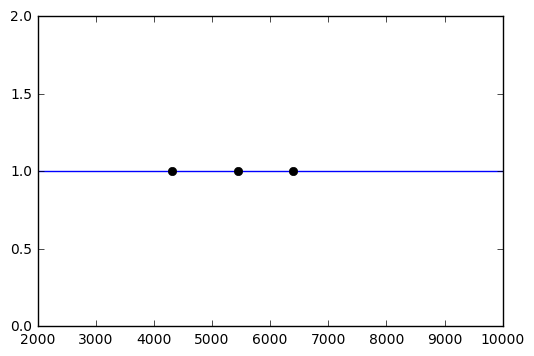

In [28]:
plt.plot(hsiao_max[0], spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.xlim([2000,10000])
plt.ylim([0,2])
plt.show()

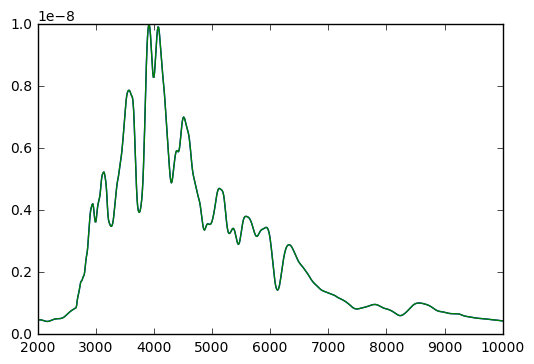

In [29]:
warped_hsiao = spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [30]:
Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(hsiao_max[1]), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag, Vmag, Rmag
print Bmag - Vmag, Vmag - Rmag

Bflux = B.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag

Vflux = V.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag

Rflux = R.get_flux(np.asarray(hsiao_max[0]), np.asarray(warped_hsiao), axis = -1)
Rmag = -2.5 * np.log10(Rflux) - R.Vega_zero_mag

print Bmag - Vmag, Vmag - Rmag

-0.0371200866077 0.0423958457655 0.0355232036651
-0.0795159323732 0.00687264210036
-0.079515943888 0.00687264266107


In [31]:
comp = composites_p1[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [32]:
print true_Bmag, true_Vmag, true_Rmag

-19.3793362873 -19.2455311305 -19.1413091971


In [33]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag
print true_BmV, true_VmR

-0.133805156865 -0.10422193338


In [34]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 1.03333334  1.03333333  0.95      ]
-0.0782875049926 -0.0828109201571
[ 1.05000001  1.05        0.9       ]
-0.0773296001607 -0.158197606426
[ 1.05555557  0.97222222  0.96666667]
-0.173604599397 0.00561625451201
[ 1.0925926   1.0037037   0.94444444]
-0.176182794144 -0.052436752098
[ 1.06172841  1.05246914  0.96296296]
-0.0883704491071 -0.0873732779445
[ 1.06481483  1.09259259  0.96111111]
-0.0476651970734 -0.132023853685
[ 1.07510289  1.05967078  0.90493827]
-0.0941122489618 -0.161112022362
[ 1.06882717  1.04475309  0.9287037 ]
-0.104247592634 -0.117362248542
[ 1.01666668  1.08333333  0.95      ]
-0.00337287104971 -0.137968809062
[ 1.07361112  1.02361111  0.94583333]
-0.133419637446 -0.0742423907657
[ 1.

In [35]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

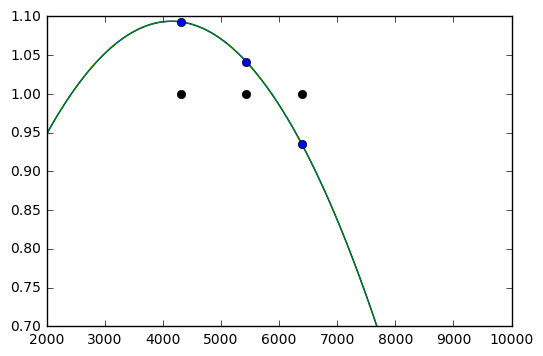

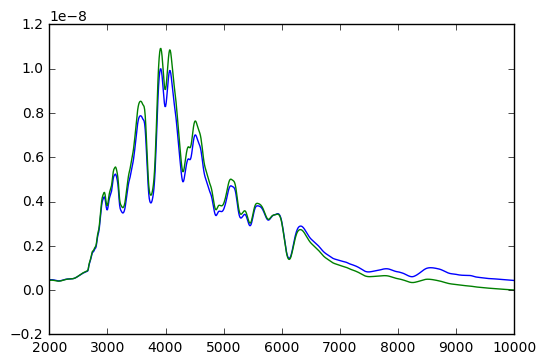

In [36]:
warped_hsiao = best_spline_func*hsiao_max[1]
# plt.plot(hsiao_max[0], hsiao_max[1])
# plt.plot(hsiao_max[0], warped_hsiao)
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.1])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [37]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template = composite.supernova(wave_interp_h, flux_interp_h)
h_template.phase_array = np.zeros(len(flux_interp_h))

Comp v =  10411.4692043
Hsiao v =  10997.3983334
Nugent v =  3177.33131873
SALT2 v =  10704.3006753
0.841962460349
Phase:  0.346829047017
dm15:  0.841962460349
Redshift:  0.0230808176438


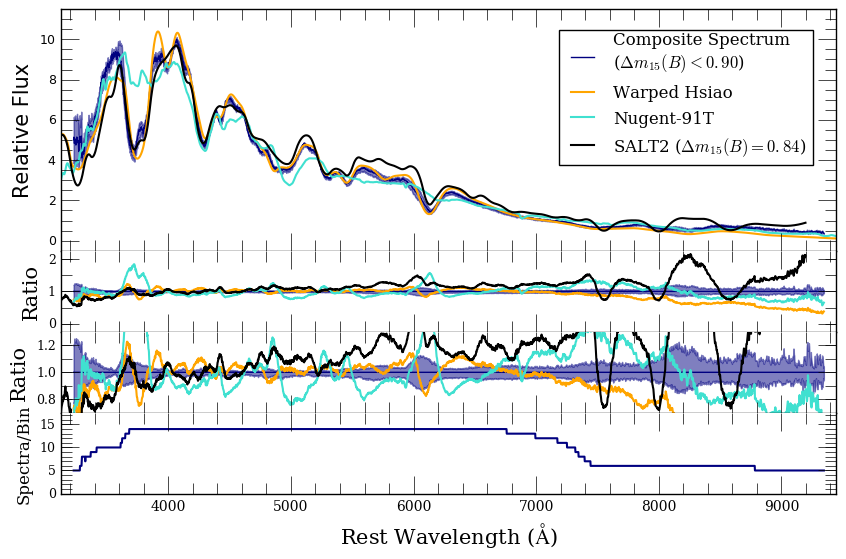

In [38]:
comps_and_temps = []
for comp in composites_p1:
    comps_and_temps.append(comp)
    
srange = np.where((p1_salt_template.wavelength > 2000.) & (p1_salt_template.wavelength < 9200))[0]
p1_salt_template.x1 = srange[0]
p1_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template)
comps_and_temps.append(nug91t_template)
comps_and_temps.append(p1_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "Nugent"
comps_and_temps[3].name = "SALT2"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
print np.average(comps_and_temps[0].dm15_array[comps_and_temps[0].x1:comps_and_temps[0].x2])
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2], comps_and_temps[3]], include_spec_bin=True, 
                     legend_labels = ["Composite Spectrum \n($\Delta m_{15} (B) < 0.90$)", "Warped Hsiao", "Nugent-91T", "SALT2 ($\Delta m_{15} (B) = 0.84$)"],
#                      rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_lowdm15')

In [39]:
comp = composites_m2[0]

true_Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Bmag = -2.5 * np.log10(true_Bflux) - B.Vega_zero_mag

true_Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Vmag = -2.5 * np.log10(true_Vflux) - V.Vega_zero_mag

true_Rflux = R.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
true_Rmag = -2.5 * np.log10(true_Rflux) - R.Vega_zero_mag

In [40]:
true_BmV = true_Bmag - true_Vmag
true_VmR = true_Vmag - true_Rmag

In [41]:
best_knots = opt.minimize(color_residuals, spline_knot_vals, args = (true_BmV, true_VmR, hsiao_max), method = 'Nelder-Mead').x
print best_knots

[ 1.00000001  1.          1.        ]
-0.079515943888 0.00687264266107
[ 1.05000001  1.          1.        ]
-0.135497477458 0.00966655441418
[ 1.00000001  1.05        1.        ]
-0.0221791626868 -0.0479932773108
[ 1.00000001  1.          1.05      ]
-0.0802701495813 0.0585216073775
[ 0.95000001  1.03333333  1.03333333]
0.017914059335 0.00232544400635
[ 0.90000001  1.05        1.05      ]
0.100069934719 -0.00121737273614
[ 0.96666668  1.05555556  0.97222222]
0.0243518121721 -0.0863490246953
[ 0.99166668  1.01388889  1.03055556]
-0.0542391366983 0.0229709304698
[ 0.96111112  1.06481481  1.04259259]
0.0399153309418 -0.0212596774314
[ 0.93518519  1.02469136  1.07098765]
0.025357707484 0.0491331167592
[ 0.90277779  1.01203704  1.10648148]
0.0506833077811 0.0959699553186
[ 0.90586421  1.06800412  1.06738683]
0.112487092211 -0.00235314200495
[ 0.97021606  1.0274177   1.03976337]
-0.0135214236816 0.0164792633567
[ 0.94248972  0.99214678  1.05346365]
-0.0214073868293 0.0678020442806
[ 0.94714

In [42]:
best_spline = inter.splrep(spline_knot_locs, best_knots, k=2)
best_spline_func = inter.splev(hsiao_max[0], best_spline, ext = 0)

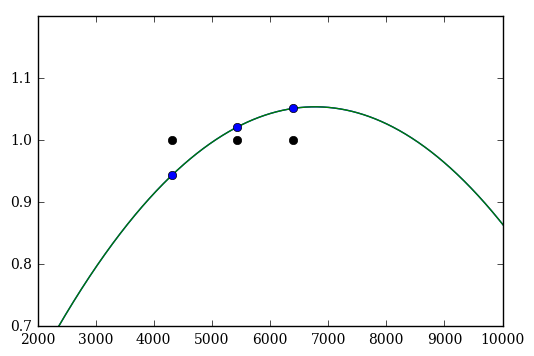

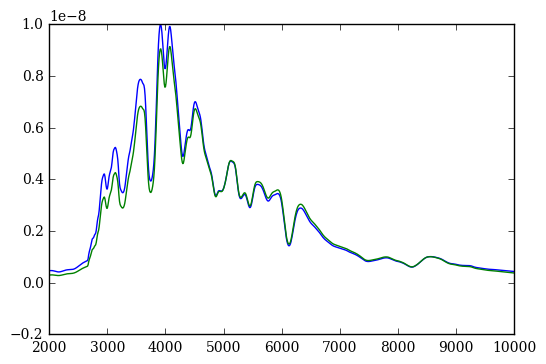

In [43]:
warped_hsiao = best_spline_func*hsiao_max[1]
plt.plot(hsiao_max[0], warped_hsiao/hsiao_max[1])
plt.plot(hsiao_max[0], best_spline_func)
plt.plot(spline_knot_locs, spline_knot_vals, 'ko')
plt.plot(spline_knot_locs, best_knots, 'bo')
plt.xlim([2000,10000])
plt.ylim([.7,1.2])
plt.show()
plt.plot(hsiao_max[0], hsiao_max[1])
plt.plot(hsiao_max[0], warped_hsiao)
plt.xlim([2000,10000])
plt.show()

In [44]:
wave_h = hsiao_max[0]
flux_h = warped_hsiao
wave_interp_h = np.arange(1000., 12000., dtype=int, step=2)
flux_spl_h = inter.splrep(wave_h, flux_h)
flux_interp_h = inter.splev(wave_interp_h, flux_spl_h, ext = 3)
h_template_2 = composite.supernova(wave_interp_h, flux_interp_h)
h_template_2.phase_array = np.zeros(len(flux_interp_h))

Comp v =  11388.6091782
Hsiao v =  10997.3983334
SALT2 v =  12466.8773158
Phase:  -0.934684747753
dm15:  1.59085920257
Redshift:  0.0167914097143


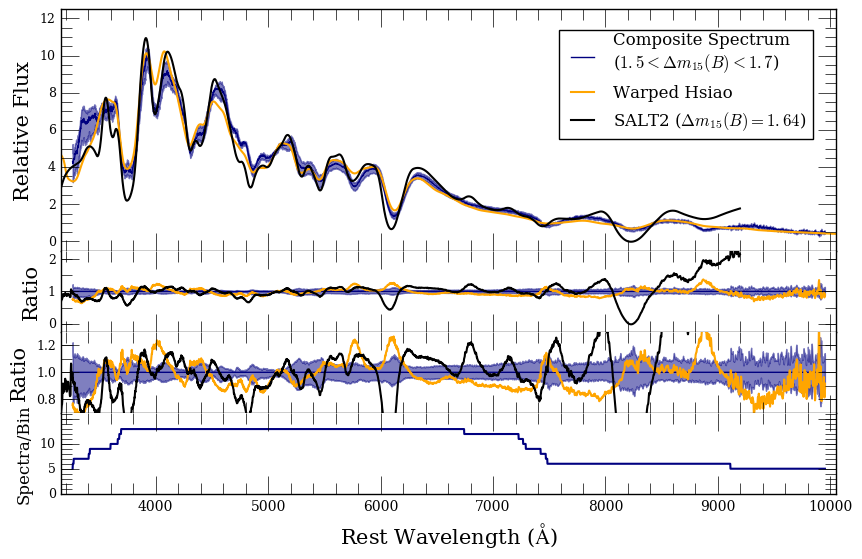

In [45]:
comps_and_temps = []
for comp in composites_m2:
    comps_and_temps.append(comp)
    
srange = np.where((m2_salt_template.wavelength > 2000.) & (m2_salt_template.wavelength < 9200))[0]
m2_salt_template.x1 = srange[0]
m2_salt_template.x2 = srange[-1]

comps_and_temps.append(h_template_2)
comps_and_temps.append(m2_salt_template)
comps_and_temps, scales = composite.optimize_scales(comps_and_temps, comps_and_temps[0], True)

comps_and_temps[0].name = "Comp"
comps_and_temps[1].name = "Hsiao"
comps_and_temps[2].name = "SALT2"
for comp in comps_and_temps:
    v_strong, si_min_wave = sa.measure_velocity(comp.wavelength[comp.x1:comp.x2],comp.flux[comp.x1:comp.x2], 5900., 6300.)
    print comp.name, 'v = ', v_strong
query_db.scaled_plot([comps_and_temps[0], comps_and_temps[1], comps_and_temps[2]], include_spec_bin=True, legend_labels = ["Composite Spectrum \n($ 1.5 < \Delta m_{15} (B) < 1.7$)", "Warped Hsiao", "SALT2 ($\Delta m_{15} (B) = 1.64$)"],
                     rm_last_label=True,
                     savename = 'template_comparisons_updated/temp_max_light_middm15')